In [ ]:
!pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
#!pip install openai
#!pip install tiktoken

In [2]:
import pandas as pd
import numpy as np
import datetime
import spacy #for text analysis
import lucem_illud #for text analysis
import collections #for counting
import re

In [3]:
#connect with drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Bo_RA/

/content/gdrive/MyDrive/Bo_RA


In [5]:
%%time
and_df = pd.read_csv('android_app_versions_versions_US.csv', sep = '|') 
#the .dta file crashes my 25G RAM machine, I have to convert the state file to csv to read it
and_df.head()

CPU times: user 4.52 s, sys: 933 ms, total: 5.45 s
Wall time: 6.69 s


,app_id,version,description,date
0,Draziw.Button.Mines,1.7.6,None,2018-09-24
1,Draziw.Button.Mines,1.4.7,Minesweeper Old School for Android is Classica...,2015-04-01
2,Draziw.Button.Mines,1.5.2,fix timer :),2016-12-09
3,Draziw.Button.Mines,1.17.5,None,2023-01-28
4,Draziw.Button.Mines,1.4.9,Minesweeper for Android is Classical minesweep...,2015-08-06


In [ ]:
#to get a sense of what the descriptions look like
for i in list(and_df['description'].sample(100)):
    print('-'*10)
    print(i)

In [5]:
and_df = pd.read_pickle('android_app.pickle') #if you were to read the stored data

In [18]:
%%time
and_df.to_pickle('android_app.pickle') #stored at 2023.06.03 3:09 am

CPU times: user 23.5 s, sys: 4.02 s, total: 27.5 s
Wall time: 31.1 s


In [6]:
and_df.head()

,app_id,version,description,date,description_raw,description_tk,len_word,len_char,len_char_ttl,description_nm,version_lag,update_by_num,dist_lst,update_num_dist,para,feature_score,bug_score,update_by_direct_mention,privacy_mention
6,Draziw.Button.Mines,1.4.4,minesweeper old school for android is classica...,2014-09-26,Minesweeper Old School for Android is Classica...,"[Minesweeper, Old, School, for, Android, is, C...",64,306,400,"[minesweeper, old, school, android, classical,...",NaN,NaN,NaN,NaN,8,0.026316,0.0,0,0
26,Draziw.Button.Mines,1.4.5,minesweeper old school for android is classica...,2014-12-10,Minesweeper Old School for Android is Classica...,"[Minesweeper, Old, School, for, Android, is, C...",64,306,400,"[minesweeper, old, school, android, classical,...",1.4.4,3.0,"[0, 0, 1, 0, 0, 0, 0]",1.0,8,0.026316,0.0,0,0
1,Draziw.Button.Mines,1.4.7,minesweeper old school for android is classica...,2015-04-01,Minesweeper Old School for Android is Classica...,"[Minesweeper, Old, School, for, Android, is, C...",64,306,400,"[minesweeper, old, school, android, classical,...",1.4.5,3.0,"[0, 0, 2, 0, 0, 0, 0]",2.0,8,0.026316,0.0,0,0
16,Draziw.Button.Mines,1.4.8,minesweeper old school for android is classica...,2015-04-20,Minesweeper Old School for Android is Classica...,"[Minesweeper, Old, School, for, Android, is, C...",64,306,400,"[minesweeper, old, school, android, classical,...",1.4.7,3.0,"[0, 0, 1, 0, 0, 0, 0]",1.0,8,0.026316,0.0,0,0
4,Draziw.Button.Mines,1.4.9,minesweeper for android is classical minesweep...,2015-08-06,Minesweeper for Android is Classical minesweep...,"[Minesweeper, for, Android, is, Classical, min...",60,288,378,"[minesweeper, android, classical, minesweeper,...",1.4.8,3.0,"[0, 0, 1, 0, 0, 0, 0]",1.0,8,0.029412,0.0,0,0


## Task 1
- At the app-month level, calculate the number of version updates for both iOs and Android apps.

In [9]:
#aggregate observations to app-month level
and_df['ym'] = pd.to_datetime(and_df['date']).dt.to_period('M')
count_df = and_df.groupby(['app_id', 'ym']).count().reset_index()[['app_id', 'ym', 'version']]
count_df = count_df.rename(columns = {'version': 'num_update'})
count_df.head()

,app_id,ym,num_update
0,Draziw.Button.Mines,2014-09,1
1,Draziw.Button.Mines,2014-12,1
2,Draziw.Button.Mines,2015-04,2
3,Draziw.Button.Mines,2015-08,1
4,Draziw.Button.Mines,2016-01,3


To generate a complete app-month panel, I search for the earliest and the latest update date for each app, and create a list of complete year-month index, then for the months with out updates, input 0.

The whole sample period ranging from 2009 to 2023, however, apps may not exit for the entire 14 years. To avoid bias, I record the minimum and maximum update date and only count for observations within the window. 

In [10]:
%%time
#to generate a complete id-month panel, first create a blank dataframe of all complete id-month index
#then merge it with the previous dataframe and input 0 for months without updates
app_id_list = list(count_df['app_id'].unique())
count_df_full = pd.DataFrame()
month_lst_full = []
app_id_lst_full = []
for id in app_id_list:
  min_month = min(count_df[count_df['app_id'] == id]['ym'])
  max_month = max(count_df[count_df['app_id'] == id]['ym'])
  month_lst = pd.date_range(min_month.to_timestamp(), max_month.to_timestamp() + datetime.timedelta(days=1), freq='MS').strftime("%Y-%m").tolist()                 
  month_lst_full = month_lst_full + month_lst
  app_id_lst_full = app_id_lst_full + [id]*len(month_lst)
count_df_full['app_id'] = app_id_lst_full
count_df_full['ym'] = month_lst_full

CPU times: user 39min 12s, sys: 17.2 s, total: 39min 29s
Wall time: 39min 26s


In [11]:
count_df_full #check

,app_id,ym
0,Draziw.Button.Mines,2014-09
1,Draziw.Button.Mines,2014-10
2,Draziw.Button.Mines,2014-11
3,Draziw.Button.Mines,2014-12
4,Draziw.Button.Mines,2015-01
...,...,...
1175537,zonyagames.rs2,2022-02
1175538,zonyagames.rs2,2022-03
1175539,zonyagames.rs2,2022-04
1175540,zonyagames.rs2,2022-05


In [12]:
count_df_full['ym'] = count_df_full['ym'].apply(lambda x: str(x))

In [13]:
count_df['ym'] = count_df['ym'].apply(lambda x: str(x))

In [14]:
count_df = pd.merge(count_df, count_df_full, on = ['app_id', 'ym'], how = 'outer')
count_df = count_df.replace(np.nan, 0)
count_df

,app_id,ym,num_update
0,Draziw.Button.Mines,2014-09,1.0
1,Draziw.Button.Mines,2014-12,1.0
2,Draziw.Button.Mines,2015-04,2.0
3,Draziw.Button.Mines,2015-08,1.0
4,Draziw.Button.Mines,2016-01,3.0
...,...,...,...
1175537,zombie.survival.online.craft,2021-11,0.0
1175538,zombie.survival.online.craft,2022-02,0.0
1175539,zonyagames.rs2,2022-03,0.0
1175540,zonyagames.rs2,2022-04,0.0


,num_update
mean,0.980963
std,1.475677
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,31.000000


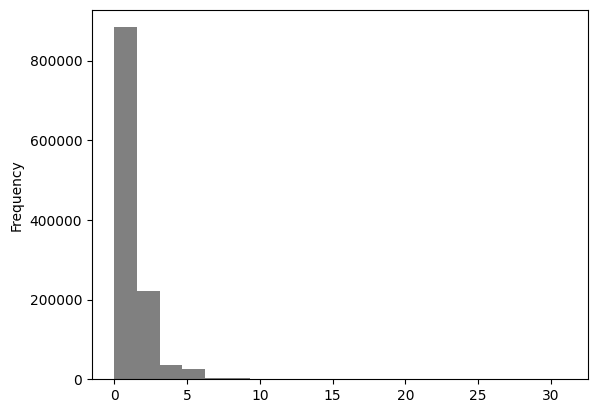

In [16]:
count_df.to_csv('android_num_update_app_month.csv')
count_df['num_update'].plot.hist(bins=20, color = 'grey');
count_df.describe()[1:]

## Task 2
- At the app-update level, construct the total length of the text per version update description (drop unnecessary characters, indents, and blank spaces). Length is measured both in characters and in words.

In [6]:
nlp = spacy.load("en_core_web_sm")

In [17]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [18]:
and_df['description_raw'] = and_df['description'] #store raw description

In [26]:
and_df['description'] = and_df['description'].apply(lambda x: '' if x == 'None' else x)
# 137751 descriptions are 'None', replace them with ''
and_df['description'] = and_df['description'].apply(lambda x: '' if type(x) == float else x)
# 36828 descriptions are NA, replace them with ''
and_df['description'] = and_df['description'].apply(lambda x: x.replace('&#39;', "'").\
                                                    replace('&amp;', "&").replace("&quot;", "'").\
                                                    replace('<br/>', ' ').replace('<br>', ' ').\
                                                    replace('<p>', ' ').replace('</p>', ' '))
#replace common html syntax

In [29]:
sum(and_df['description'].apply(lambda x: len(x) == 0))/np.shape(and_df)[0]
#check the percentage of obs without description

0.1513895958729666

In [31]:
def replace_itemizer(target, char_lst):
  for char in char_lst:
    if char == '\n':
      target = target.replace(char, ' ')
      #replace by blank in case there are no blanks between the the line breaker and the next word
    else:
      target = target.replace(char, '')
  return target

In [32]:
char_lst = ('\n', '-', '•', '*', '◉', '+', '●', '>', '°', '✩', '■', '=', '▶', '◆', '✓', '・')
and_df['description'] = and_df['description'].apply(lambda x: replace_itemizer(x, char_lst)) 
#remove itemizer characters (these characters are special and cannot be removed by text normalization)

In [33]:
%%time
and_df['description_tk'] =  and_df['description'].apply(lambda x: lucem_illud.word_tokenize(x)) #tokenization

CPU times: user 1h 19min 24s, sys: 19.8 s, total: 1h 19min 43s
Wall time: 1h 19min 33s


In [39]:
and_df.sort_values(['app_id'])['description_tk'].sample(20) #the tokenization went well

995226     [You, know, the, drill, update, time, In, this...
946030                                          [bug, fixes]
960864                                        [New, version]
852246     [Various, bug, fixes, and, performance, enhanc...
1034646                                                   []
135163     [Hi, Spinners, Here, 's, what, 's, new, Minor,...
1152807    [Improved, description, of, limits, 💸, Fix, wr...
327651     [We, ’re, grabbing, an, extra, cup, of, coffee...
904432     [We, update, the, Uber, app, as, often, as, po...
277432     [Version, 3.50.1.5, Fixed, system, settings, o...
904387     [Improved, printer, support, improved, notific...
502308                                                    []
48956      [SHINY, NEW, LANGUAGES, Added, Italian, Dutch,...
260117                           [Improve, UI, Small, Fixes]
314422                [Minor, bug, fixes, and, improvements]
269299          [Minor, fixes, and, stability, improvements]
126205                  

In [40]:
and_df['len_word'] = and_df['description_tk'].apply(lambda x: len(x))

In [41]:
and_df['len_char'] = and_df['description_tk'].apply(lambda x: len(''.join(x)))

In [45]:
and_df['len_char_ttl'] = and_df['description_raw'].apply(lambda x: len(x))

In [46]:
and_df[['len_word', 'len_char', 'len_char_ttl']].describe()[1:]

,len_word,len_char,len_char_ttl
mean,30.617790,159.110598,197.986011
std,56.397552,351.672688,426.125335
min,0.000000,0.000000,0.000000
25%,4.000000,21.000000,24.000000
50%,14.000000,74.000000,92.000000
75%,40.000000,195.000000,244.000000
max,741.000000,20579.000000,23020.000000


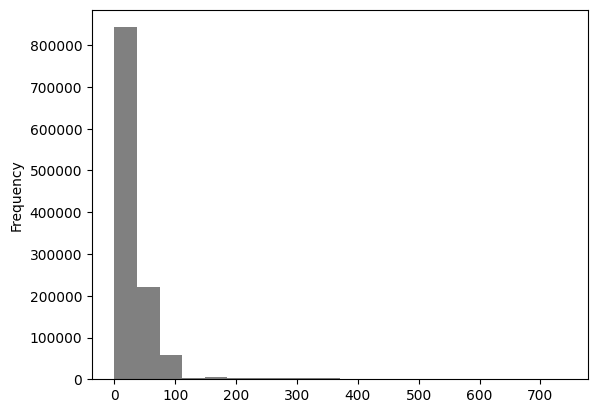

In [47]:
and_df['len_word'].plot.hist(bins=20, color = 'grey');

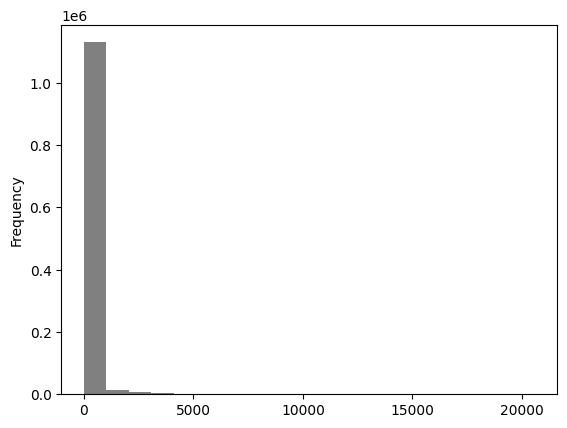

In [48]:
and_df['len_char'].plot.hist(bins=20, color = 'grey');

To prepare for the subsequent tasks, also normalize the text (i.e., turn characters to lower cases, remove stop words, and lemmetize)

In [49]:
def normalizeTokens(word_list, extra_stop=[]):
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    #add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        #if it's not a stop word or punctuation mark, add it to the list
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            #add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [51]:
%%time
and_df['description_nm'] =  and_df['description'].apply(lambda x: normalizeTokens(x)) #for subsequent tasks

CPU times: user 3h 50min 37s, sys: 36.4 s, total: 3h 51min 13s
Wall time: 3h 51min 2s


In [52]:
and_df

,app_id,version,description,date,description_raw,description_tk,len_word,len_char,len_char_ttl,description_nm
0,Draziw.Button.Mines,1.7.6,,2018-09-24,,[],0,0,0,[]
1,Draziw.Button.Mines,1.4.7,Minesweeper Old School for Android is Classica...,2015-04-01,Minesweeper Old School for Android is Classica...,"[Minesweeper, Old, School, for, Android, is, C...",64,306,400,"[minesweeper, old, school, android, classical,..."
2,Draziw.Button.Mines,1.5.2,fix timer :),2016-12-09,fix timer :),"[fix, timer]",2,8,12,"[fix, timer]"
3,Draziw.Button.Mines,1.17.5,,2023-01-28,,[],0,0,0,[]
4,Draziw.Button.Mines,1.4.9,Minesweeper for Android is Classical minesweep...,2015-08-06,Minesweeper for Android is Classical minesweep...,"[Minesweeper, for, Android, is, Classical, min...",60,288,378,"[minesweeper, android, classical, minesweeper,..."
...,...,...,...,...,...,...,...,...,...,...
1153172,zonek.design.paintbynumbers,2.8,Ver 2.8 : Optimization : faster and smoother...,2019-03-14,Ver 2.8 : - Optimization : faster and smoothe...,"[Ver, 2.8, Optimization, faster, and, smoother...",8,44,66,"[ver, optimization, fast, smoother, bug, fix]"
1153173,zonek.design.paintbynumbers,1.9,Ver1.9: Fix OOM crash!,2019-03-11,Ver1.9: -Fix OOM crash!,"[Ver1.9, Fix, OOM, crash]",4,17,23,"[ver1.9, fix, oom, crash]"
1153174,zonek.design.paintbynumbers,3.0,Ver 3.0 : Optimization : faster and smoother...,2019-03-18,Ver 3.0 : - Optimization : faster and smoothe...,"[Ver, 3.0, Optimization, faster, and, smoother...",17,80,114,"[ver, optimization, fast, smoother, bug, fix, ..."
1153175,zonyagames.rs2,2202,,2022-02-22,,[],0,0,0,[]


In [53]:
%%time
and_df.to_pickle('android.pickle')

CPU times: user 32.9 s, sys: 7.35 s, total: 40.2 s
Wall time: 45.1 s


## Task 3
- (open-ended) determine major version updates for each app. Some version update descriptions mention "major updates," while others say "minor fixes". No unified keywords indicate major version updates across all apps, so you may come up with a dictionary based on some examples. Another way to do this is that version updates from 1.1.4 to 1.2 is more likely to be major update compared to version updates from 1.1.4 to 1.1.5. You can construct multiple measures based on the version update descriptions and version codes.

### Measure 1: by version number
Reference: https://dl.acm.org/doi/abs/10.1145/2600428.2609560

In [78]:
and_df = and_df.sort_values(['app_id', 'date', 'version'])
and_df['version_lag'] = and_df.groupby('app_id').shift(1)['version']

In [15]:
#types of special version number: 
#1. use date as version number. e.g., 2016.06.23 -> find all XXXX.XX.XX
#2. alphabets in version number. e.g., 1.1a -> finall(r'[A-Za-z]', string)
#3. extra dot. e.g, 1..3.5 -> re.findall(r'\d+', string))
#4. use of other languages. e.g., 임시 -> findall(r'[^a-zA-Z0-9.]'), string)
#5. missing dot between numbers. e.g., 0.87 should be 0.8.7 -> absolute distance larger than 10
#6. use of special characters. e.g., + () -> findall(r'[^a-zA-Z0-9.]'), string)
def special_version_num(row):
    special = 0
    cur_ver = row['version']
    lag_ver = row['version_lag']
    if pd.isna(lag_ver):
        lag_ver = ''
    if pd.isna(cur_ver):
        cur_ver = ''
    
    lag_ver = lag_ver.replace('v.', '').replace('v', '')
    cur_ver = cur_ver.replace('v.', '').replace('v', '')

    #1, 2, 6, 4
    if len(re.findall(r'\d{4}\.\d{2}\.\d{2}', cur_ver)) != 0 or \
    len(re.findall(r'\d{4}\.\d{2}\.\d{2}', lag_ver)) != 0 or \
    len(re.findall(r'[A-Za-z]', cur_ver)) != 0 or\
    len(re.findall(r'[A-Za-z]', lag_ver)) != 0 or\
    len(re.findall(r'[^a-zA-Z0-9.]', cur_ver)) != 0 or \
    len(re.findall(r'[^a-zA-Z0-9.]', lag_ver)) != 0:
        special = 1

    cur_ver = cur_ver.split('.')
    lag_ver = lag_ver.split('.')

    #3
    if sum([len(re.findall(r'\d+', d)) == 0 for d in cur_ver]) != 0 and \
        sum([len(re.findall(r'\d+', d)) == 0 for d in lag_ver]) != 0:
            special = 1
    #5
    if np.abs(row['update_num_dist'])>=10:
        special = 1
    
    return special


In [16]:
and_df['special_version_num'] = and_df.apply(special_version_num, axis = 1)
sum(and_df['special_version_num'])/len(and_df)

0.19245961374533138

In [17]:
and_df[and_df['special_version_num'] == 1].sample(10)[['app_id', 'version', 'version_lag']]

,app_id,version,version_lag
454780,com.ibm.events.android.usopen,v.2017.08.24,6.3
996234,crush.toy,v.2017.11.12,v.2017.10.29
890322,com.transsion.phoenix,V3.1.9,V3.1.8
342364,com.freegamesstudio.thesurvivalhuntergames2,E.1.11v,E.1.11
487376,com.jetsmarter.SmartJets,6.9.298,6.9.285
277787,com.droid4you.application.wallet,7.5.61,7.5.31
598715,com.mobilecreatures.drinkwater,v.2021.12.22,v.2021.11.28
963344,com.wordgame.words.connect,2.517.1,2.497.0
464037,com.imo.android.imoim,9.8.000000004111,9.8.000000004061
848564,com.talabat,v.2021.02.09,v.2021.02.04


In [55]:
def update_by_num(row):
    #1 means major revision (change of the first digit)
    #2 means minor revision (change of the second digit)
    #3 means maintanence (change of the third digit)
    #and so on
    cur_ver = row['version']#.split('.')
    lag_ver = row['version_lag']#.split('.')
    update = np.NaN
    if type(cur_ver) == str and type(lag_ver) == str:
        cur_ver = row['version'].split('.')
        lag_ver = row['version_lag'].split('.')
        for i in range(min(len(cur_ver), len(lag_ver))):
            if cur_ver[i] != lag_ver[i]:
                update = i+1
                break 
                #add break to record the highest digit change: 
                #e.g., from 1.3 to 2.0, both the first and second digit change
                #but it is classified as major revision
    return update

In [109]:
def update_distance(row):
    cur_ver = row['version']
    lag_ver = row['version_lag']
    dist_lst = np.NaN
    if type(cur_ver) == str and type(lag_ver) == str: #screen out non-string obs
        cur_ver = row['version'].replace('v.', '').replace('v', '') #some version number would start with v: e.g., v.2016.06.23
        lag_ver = row['version_lag'].replace('v.', '').replace('v', '')
        #print(cur_ver)
        if len(re.findall(r'[A-Za-z]', cur_ver)) == 0 and len(re.findall(r'[A-Za-z]', lag_ver)) == 0 and \
        not '(' in cur_ver and not '+' in cur_ver: 
            #screen out irregularities: some version number has alphabets and special characters in it, ignore those
            cur_ver = cur_ver.split('.')
            lag_ver = lag_ver.split('.')
            cur_ver = cur_ver + ['0']*(7 - len(cur_ver)) #7 is the maximum number of version digits in the dataset
            lag_ver = lag_ver + ['0']*(7 - len(lag_ver))
            #print(cur_ver)
            if sum([len(re.findall(r'\d+', d)) == 0 for d in cur_ver]) == 0 and \
            sum([len(re.findall(r'\d+', d)) == 0 for d in lag_ver]) == 0: 
            #screen out irregularity: e.g., "1..3.5", "임시", ignore those
                dist_lst = [int(re.findall(r'\d+', cur_ver[i])[0]) - \
                            int(re.findall(r'\d+', lag_ver[i])[0]) for i in range(len(cur_ver))]
    return dist_lst

In [57]:
def first_non_zero_dist(dist_list):
    if type(dist_list) != float:
        non_zero_dist = [d for d in dist_list if d != 0]
        if len(non_zero_dist) != 0:
            return non_zero_dist[0]
        else:
            return np.NaN
    else:
        return np.NaN

In [110]:
%%time
and_df['dist_lst'] = and_df.apply(update_distance, axis = 1)

CPU times: user 53.3 s, sys: 432 ms, total: 53.7 s
Wall time: 53.8 s


In [111]:
and_df['update_num_dist'] = and_df['dist_lst'].apply(lambda x: first_non_zero_dist(x))

In [112]:
and_df['update_num_dist'].describe()[1:]

mean   -1.845229e+07
std     4.337597e+10
min    -2.018031e+13
25%     1.000000e+00
50%     1.000000e+00
75%     2.000000e+00
max     2.016110e+13
Name: update_num_dist, dtype: float64

In [115]:
print(len(and_df[and_df['update_num_dist'] < 0])) 
# 9556 outliers - distance less than zero, may consider drop them in analysis

#and_df[and_df['update_num_dist'] == min(and_df[and_df['update_num_dist'].isna()==False]['update_num_dist'])] 
#take a look at the outliers
and_df[and_df['update_num_dist'] < 0].sample(5)

9556


,app_id,version,description,date,description_raw,description_tk,len_word,len_char,len_char_ttl,description_nm,version_lag,update_by_num,dist_lst,update_num_dist
189926,com.capigami.outofmilk,4.3.2,"Shopping List, Pantry List & ToDo List in a sm...",2015-08-06,"Shopping List, Pantry List & To-Do List in a s...","[Shopping, List, Pantry, List, ToDo, List, in,...",466,2597,3256,"[shopping, list, pantry, list, todo, list, sma...",v.2012.03.28,1.0,"[-2008, 0, -26, 0, 0, 0, 0]",-2008.0
951197,com.westplain.antlife,3.5,"Add grasshopper , cicada and fly. as food. Inc...",2018-10-29,"Add grasshopper , cicada and fly. as food. Inc...","[Add, grasshopper, cicada, and, fly, as, food,...",13,70,87,"[add, grasshopper, cicada, fly, food, increase...",3.44,2.0,"[0, -39, 0, 0, 0, 0, 0]",-39.0
855909,com.tdameritrade.mobile3,5.4.2,Performance enhancements and bug fixes,2021-06-24,Performance enhancements and bug fixes,"[Performance, enhancements, and, bug, fixes]",5,34,38,"[performance, enhancement, bug, fix]",v.2021.05.28,3.0,"[-2016, -1, -26, 0, 0, 0, 0]",-2016.0
38814,co.gxgames.star,2.0.11,,2021-05-06,,[],0,0,0,[],2.0.115,3.0,"[0, 0, -104, 0, 0, 0, 0]",-104.0
967334,com.xfinitymobile.myaccount,1.4.0.023,We’ve added more details to your order stateme...,2017-08-18,We’ve added more details to your order stateme...,"[We, ’ve, added, more, details, to, your, orde...",41,168,210,"[add, detail, order, statement, fix, small, bu...",v.2017.07.12,1.0,"[-2016, -3, -12, 23, 0, 0, 0]",-2016.0


In [59]:
%%time
and_df['update_by_num'] = and_df.apply(update_by_num, axis = 1)

CPU times: user 16.7 s, sys: 690 ms, total: 17.4 s
Wall time: 17.4 s


In [60]:
and_df['update_by_num'].value_counts() #version update indicator by update observation

3.0    508810
2.0    400967
4.0    106311
1.0     90404
5.0       926
6.0       108
7.0         4
Name: update_by_num, dtype: int64

In [61]:
and_df.groupby(['update_by_num', 'app_id']).count().reset_index()[['update_by_num', 'app_id']]\
.groupby('update_by_num').count() #version update indicator by app

,app_id
update_by_num,
1.0,18370
2.0,23587
3.0,20408
4.0,4937
5.0,142
6.0,12
7.0,2


In [7]:
#and_df[and_df['update_by_num'] == 7].head() #sanity check -> there really are apps with seven-digit version numbers

I Modified the measure to accommondate cases where only digits at a certain location change throughout the sample period, e.g., only the third digit changes, 0.0.2 all the way to 0.0.80.

1. Calculated the maximum and minimum value of the original measure, and calculated their difference
2. For apps with more than three levels of update (max_min_diff <= 2), I classified updates with changes in the smallest digit to be major updates; For apps with less than three levels of update, I classified them based on the distance measure (distance larger than the 75th quantile)

In [8]:
min_max_num = and_df.groupby('app_id').agg({'update_by_num': ['min', 'max']}).reset_index()
min_max_num.columns = min_max_num.columns.droplevel()
min_max_num.columns = ['app_id',"min_update_by_num","max_update_by_num"]
min_max_num['min_max_diff'] = min_max_num['max_update_by_num'] - min_max_num['min_update_by_num']
#min_max_num = min_max_num.rename(columns={'Unnamed: 0':'app_id', "min": "min_update_by_num", "max": "max_update_by_num"})
and_df = pd.merge(and_df, min_max_num, on = 'app_id')

In [9]:
class Quantile:
    def __init__(self, q):
        self.q = q
        
    def __call__(self, x):
        return x.quantile(self.q)

def modified_update_by_num(row):
    major = 0
    if row['min_max_diff'] >= 2 and row['update_by_num'] == row['min_update_by_num']: #digits in at least three locations change
        major = 1
    if row['min_max_diff'] == 1 and row['update_by_num'] == row['min_update_by_num'] \
    and row['update_num_dist']>row['dist_p75']:
        major = 1
    if row['min_max_diff'] == 0 and row['update_num_dist']>row['dist_p75']: 
        major = 1
    
    return major

In [10]:
dist_p75 = and_df.groupby('app_id').agg(dist_p75 = ('update_num_dist', Quantile(0.75)))
and_df = pd.merge(and_df, dist_p75, on = 'app_id')

In [11]:
%%time
and_df['update_by_num_modified'] = and_df.apply(modified_update_by_num, axis = 1)

CPU times: user 13.7 s, sys: 842 ms, total: 14.6 s
Wall time: 14.5 s


In [12]:
sum(and_df['update_by_num_modified'])

78609

In [14]:
and_df[and_df['update_by_num_modified'] == 1].sample(5)[['app_id', 'version', 'date', 'version_lag', 'description', 
                                                        'update_by_num', 'update_num_dist',
                                                        'dist_p75', 'min_max_diff']]#take a look
#add a flag - special cases

,app_id,version,date,version_lag,description,update_by_num,update_num_dist,dist_p75,min_max_diff
402500,com.google.android.apps.youtube.kids,3.20.3,2018-03-09,v.2018.03.08,introducing kid profiles and a new colorful an...,1.0,-2015.0,5.0,3.0
901277,com.tvt.superliveplus,1.0,2015-12-18,0.9.1,,1.0,1.0,2.0,2.0
22312,beatmaker.edm.musicgames.FNF,1.0.13,2022-10-24,1.0.10,"1. new mod agoti, imposter, qt 2. add new son...",3.0,3.0,2.5,0.0
668185,com.opendoor.buyerapp,134.0.0,2021-06-16,133.2.0,we regularly update the app to make your buyer...,1.0,1.0,1.0,3.0
292991,com.eightsec.StrikyBall,8.0,2018-12-13,1.7,v93 : big optimizations,1.0,7.0,2.0,1.0


### Measure 2: Number of paragraphs (line breakers)
Descriptions with multiple paragraphs may involve more aspects of revision. 

In [18]:
and_df['para'] = and_df['description_raw'].apply(lambda x: x.count('<br/>') + x.count('<br>') +1 if type(x) == str and len(x)>0 else 0) #number of line breakers -> paragraphs

In [19]:
and_df['para'].describe()[1:]

mean      3.329615
std       4.169222
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max     232.000000
Name: para, dtype: float64

In [20]:
#and_df = and_df.drop(columns=['para_p75', 'para_p90']) #drop columns to release menmory

In [21]:
para_p75 = and_df.groupby('app_id').agg(para_p75 = ('para', Quantile(0.75)))
and_df = pd.merge(and_df, para_p75, on = 'app_id')
para_p75.describe()

,para_p75
count,28369.000000
mean,3.414211
std,3.567581
min,0.000000
25%,1.000000
50%,2.000000
75%,4.750000
max,112.000000


In [22]:
para_p90 = and_df.groupby('app_id').agg(para_p90 = ('para', Quantile(0.9)))
and_df = pd.merge(and_df, para_p90, on = 'app_id')
para_p90.describe()

,para_p90
count,28369.000000
mean,4.727054
std,5.043505
min,0.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,112.000000


In [29]:
def update_by_para(row):
    major = 0
    if row['para']>row['para_p90']:
        major = 1
    return major

In [30]:
and_df['update_by_para'] = and_df.apply(update_by_para, axis=1)

In [31]:
sum(and_df['update_by_para']) #167766 major revisions if set threshold .75 
#66257 major revisions if set threshold .9

66257

### Measure 3: revision content - feature update vs. bug fix
Revisions related to core features of the app tend to be major updates whereas revions that only involves bug fixes may be minor revisions or maintanences. 

In [32]:
feature_wds = set(['launch', 'introduce', 'feature', 'function',
                   'design', 'product', 'redesign', 'invent', 
                   'invention', 'unlock'])
bug_wds = set(['fix', 'bug', 'maintenance', 'issue', 'tweak', 
               'problem', 'outage', 'crash', 'fixed', 'bugfix', 
               'bugfixe','fixing', 'fixes', 'outage'])
#more parsimounous 

In [33]:
def feature_score(word_list):
    total = len(word_list)
    feature = len([e for e in word_list if e in feature_wds])
    if total > 0:
        return feature / total
    else:
        return 0

def bug_score(word_list):
    total = len(word_list)
    bug = len([e for e in word_list if e in bug_wds])
    if total > 0:
        return bug / total
    else:
        return 0

In [34]:
and_df['feature_score'] = and_df['description_nm'].apply(feature_score)
and_df['bug_score'] = and_df['description_nm'].apply(bug_score)

In [35]:
print('number of updates related to features: {}'.format(np.shape(and_df[and_df['feature_score'] !=0])[0])) 
print('number of updates related to bugs: {}'.format(np.shape(and_df[and_df['bug_score'] !=0])[0]))
and_df[['feature_score', 'bug_score']].describe()[1:]

number of updates related to features: 191717
number of updates related to bugs: 550267


,feature_score,bug_score
mean,0.010355,0.146296
std,0.034967,0.248077
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.181818
max,1.000000,1.000000


In [36]:
and_df[['feature_score', 'bug_score']].corr()
#slightly negatively correlated

,feature_score,bug_score
feature_score,1.00000,-0.08875
bug_score,-0.08875,1.00000


In [37]:
%%time
feature_q = \
and_df.groupby('app_id').agg(feature_p75 = ('feature_score', Quantile(0.75)),
                             feature_p90 = ('feature_score', Quantile(0.90)))
feature_q.describe()

CPU times: user 37.5 s, sys: 357 ms, total: 37.9 s
Wall time: 37.9 s


,feature_p75,feature_p90
count,28369.000000,28369.000000
mean,0.009805,0.022092
std,0.036560,0.051429
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.027027
max,1.000000,1.000000


In [38]:
%%time
bug_q = \
and_df.groupby('app_id').agg(bug_p25 = ('bug_score', Quantile(0.25)),
                             bug_p10 = ('bug_score', Quantile(0.10)))
bug_q.describe()

CPU times: user 35.9 s, sys: 335 ms, total: 36.3 s
Wall time: 36.4 s


,bug_p25,bug_p10
count,28369.000000,28369.000000
mean,0.063290,0.030427
std,0.166010,0.117413
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.032813,0.000000
max,1.000000,1.000000


In [39]:
and_df = pd.merge(and_df, feature_q, on = 'app_id')
and_df = pd.merge(and_df, bug_q, on = 'app_id')

In [40]:
def update_by_feature_bug(row):
    major = 0
    if (row['feature_score']> 0) and (row['feature_score']>=row['feature_p75']) and (row['bug_score']<=row['bug_p25']):
        major = 1
    return major
and_df['update_by_feature_bug']=and_df.apply(update_by_feature_bug, axis = 1)

In [41]:
len(and_df[and_df['update_by_feature_bug'] == 1])

101584

In [51]:
and_df[and_df['update_by_feature_bug'] == 1].sample(5)[['app_id', 'version', 'version_lag', 'description', 'bug_score',
                                                        'feature_score', 'update_by_feature_bug', 'update_by_num', 
                                                        'update_by_direct_mention']]#take a look

,app_id,version,version_lag,description,bug_score,feature_score,update_by_feature_bug,update_by_num,update_by_direct_mention
738558,com.rayark.sdorica,4.0.0,3.8.3,⦿ version 4.0.0 [new] season 4 related functi...,0.000000,0.028571,1,1.0,0
240787,com.crunchyroll.crunchyroid,1.1.2,1.1.1,"now with chromecast support watch over 25,00...",0.000000,0.011111,1,3.0,0
722916,com.protheme.launcher.winx.launcher,11.58,11.54,system widget resize design improved icon dr...,0.166667,0.083333,1,2.0,0
1027447,grit.storytel.app,v.2022.10.14,v.2022.10.07,"sit back, relax and step into a world of stori...",0.000000,0.076923,1,4.0,0
650127,com.nomad88.nomadmusic,1.5.1,1.4.5,"thank you for downloading nomad music, a free ...",0.041667,0.020833,1,2.0,0


### Measure 4: search for words directly suggesting major vision

In [87]:
and_df['description'] = and_df['description'].apply(lambda x: x.lower())
major_wds = ['major update', 'big update',  'huge update', 'important update', 'biggest update', 'critical update',
             'major revision','big revision','huge revision','important revision', 'biggest revision', 'critical revision',
             'major improvement', 'big improvement', 'huge improvement','huge improvement', 'important improvement', 'biggest improvement', 'critical improvement',
             'major upgrade', 'big upgrade',  'huge upgrade', 'important upgrade', 'biggest upgrade', 'critical upgrade']

non_major_wds = [i+'s coming' for i in major_wds] + ['previous '+ i for i in major_wds] + \
                ['stay tuned for a '+ i for i in major_wds] + [i+'is coming' for i in major_wds] +\
                [i+' coming' for i in major_wds] + ['last '+i for i in major_wds] + ['next '+i for i in major_wds]

def major_update(text):
    n = 0
    for word in major_wds:
        if word in text:
            n +=1
    for word in non_major_wds:
        if word in text:
            n -=1
    if n > 0:
        return 1
    else:
        return 0

and_df['update_by_direct_mention'] = and_df['description'].apply(major_update)

In [88]:
and_df['update_by_direct_mention'].value_counts()

0    1145860
1       7317
Name: update_by_direct_mention, dtype: int64

In [89]:
for i in list(and_df[and_df['update_by_direct_mention'] == 1].sample(n=5, random_state=1)['description']):
    print('-'*10)
    print(i)#take a look
and_df[and_df['update_by_direct_mention'] == 1].sample(n=5, random_state=1)[['app_id', 'version', 'version_lag', 'description', 'bug_score',
                                                        'feature_score', 'update_by_feature_bug', 'update_by_num', 
                                                        'update_by_direct_mention']]

----------
v4.97.02  big update  added new earning opportunities  updated design and information
----------
huge improvement with new engine.
----------
get ready for a big update filled with fun! play 380 new levels with new challenging goals! we also made lots of small bug fixes.
----------
 fixes, big improvements and memory optimizations  app became 100% free  edge mask  fingerprint (if supported)  the smoothest edge lighting in this universe and parallel universes.  new option: lights when open recent apps menu. and on incoming calls..  fix run on calls. ability to enable multiple run options at the same time  clock's face can be yours; circular image background for clocks  invisible music controller by swipe, or buttons  option to not run while charging
----------
‼️new big update‼️  🌎 new open world. 🏍️ new motorbikes. 🙋🏻‍♂️🙋🏻‍♀️ characters. choose your favorite biker. 🛠️customizations. create a unique motorcycle! 🏁 new games. enjoy with radar, time trial and parkour test!


,app_id,version,version_lag,description,bug_score,feature_score,update_by_feature_bug,update_by_num,update_by_direct_mention
837857,com.suneoneapps.earnextraincome,4.97.02,4.97.01,v4.97.02 big update added new earning opport...,0.000000,0.1,1,3.0,1
315677,com.fancyapp.qrcode.barcode.scanner.reader,1.4.3,1.3.5,huge improvement with new engine.,0.000000,0.0,0,2.0,1
9663,air.com.smileygamer.christmassweeper3,v.2018.03.08,2.4,get ready for a big update filled with fun! pl...,0.133333,0.0,0,3.0,1
916555,com.used.aoe,3.4.2,3.4.0,"fixes, big improvements and memory optimizati...",0.040816,0.0,0,3.0,1
198982,com.cerebelliumapps.motoextremeracing,3.1.9,3.1.8,‼️new big update‼️ 🌎 new open world. 🏍️ new m...,0.000000,0.0,0,3.0,1


### Putting it all together

In [56]:
and_df[['update_by_num_modified', 'update_by_para', 
        'update_by_feature_bug', 'update_by_direct_mention']].corr() #slightly positively correlated

,update_by_num_modified,update_by_para,update_by_feature_bug,update_by_direct_mention
update_by_num_modified,1.000000,0.027197,0.016926,0.012369
update_by_para,0.027197,1.000000,0.101991,0.038575
update_by_feature_bug,0.016926,0.101991,1.000000,0.029760
update_by_direct_mention,0.012369,0.038575,0.029760,1.000000


In [57]:
temp_lst = []
for i in ['update_by_direct_mention', 'update_by_num_modified', 'update_by_para', 'update_by_feature_bug']:
    for j in ['update_by_direct_mention', 'update_by_num_modified', 'update_by_para', 'update_by_feature_bug']:
        if j not in temp_lst:
            if i == j:
                print('number of major revision identified by {}: {}'.format(i, len(and_df.loc[(and_df[i]==1)&(and_df[j]==1)])))
            else:
                print('number of major revision identified by both {} and {}: {}'.format(i, j, len(and_df.loc[(and_df[i]==1)&(and_df[j]==1)])))
            temp_lst.append(i)
#app

number of major revision identified by update_by_direct_mention: 6599
number of major revision identified by both update_by_direct_mention and update_by_num_modified: 721
number of major revision identified by both update_by_direct_mention and update_by_para: 1160
number of major revision identified by both update_by_direct_mention and update_by_feature_bug: 1315
number of major revision identified by update_by_num_modified: 78609
number of major revision identified by both update_by_num_modified and update_by_para: 6356
number of major revision identified by both update_by_num_modified and update_by_feature_bug: 8319
number of major revision identified by update_by_para: 66257
number of major revision identified by both update_by_para and update_by_feature_bug: 13594
number of major revision identified by update_by_feature_bug: 101584


In [6]:
#number of major revision by app
and_df.groupby('app_id').sum()['update_by_direct_mention'].describe()

count    28369.000000
mean         0.232613
std          1.819533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        129.000000
Name: update_by_direct_mention, dtype: float64

In [8]:
and_df.groupby('app_id').sum()['update_by_num_modified'].describe()

count    28369.000000
mean         2.770947
std          7.278632
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        318.000000
Name: update_by_num_modified, dtype: float64

In [9]:
and_df.groupby('app_id').sum()['update_by_para'].describe()

count    28369.000000
mean         2.335542
std          3.920040
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         51.000000
Name: update_by_para, dtype: float64

In [10]:
and_df.groupby('app_id').sum()['update_by_feature_bug'].describe()

count    28369.000000
mean         3.580810
std          9.979344
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max        287.000000
Name: update_by_feature_bug, dtype: float64

## Task 4
- (open-ended) determine the keywords for each app based on the version update descriptions. The keywords should pick up information on the functions and characteristics of the app. This may need some ML package to learn the patterns of language and is open-ended. 

In [138]:
%%time
#first create a new df aggregate data to app level with tokenized&normalized word lists
and_by_app = and_df.groupby('app_id').agg({'description_nm': 'sum', 'description': 'sum'}).reset_index()

CPU times: user 8.12 s, sys: 783 ms, total: 8.91 s
Wall time: 8.85 s


In [140]:
and_by_app.head()

,app_id,description_nm,description
0,Draziw.Button.Mines,"[minesweeper, old, school, android, classical,...",minesweeper old school for android is classica...
1,Kal.FlightInfo,"[new, korean, air, mobile, application, select...","with the new korean air mobile application, yo..."
2,SavySoda.PrivateBrowsing,"[free, screen, private, browsing, android, ios...",free full screen private browsing for android ...
3,aascopegames.dancesemotes.battleroyale,[],
4,aasuited.net.word,"[un, dessin, une, expression, essayez, de, tro...","un dessin, une expression : essayez de trouver..."


### Measure 1: word frequency

In [144]:
update_wds = set(['fix', 'bug', 'maintenance', 'performance', 'optimize', 'optimise', 'optimization', 
                  'improve', 'improvement', 'fixed', 'remove', 'update', 'revise', 'add', 'new', 
                  'app', 'thank', 'issue', 'outage', 'crash', 'ui', 'minor', 'fixe', 'release', 
                  'fixing', 'bugfix', 'feature', 'version', 'hey', 'enjoy', 'support', 'you',
                  'upgrade', 'enhance', 'well', 'compatibility', 'welcome', 'enhancement'])
and_by_app['description_nm_1'] = and_by_app['description_nm'].apply(lambda x: [e for e in x if e not in update_wds])

#remove commonly used words that are unrelated to functions and characteristics of the app

In [145]:
and_by_app['freq_wds'] = and_by_app['description_nm_1'].apply(lambda x: \
                                                            list(dict(collections.Counter(x).most_common(20)).keys()))

In [146]:
and_by_app[['app_id', 'freq_wds']].sample(10) #take a look, the key words seem to pick up some feature-related information but still quite noisy

,app_id,freq_wds
21313,com.tapchamps.app,"[game, badge, purchase, boost, redeem, day, us..."
10660,com.hanna.zumapawpatroladventure.games.free,[]
2494,com.adoreme.android,"[adore, review, product, vote, look, easy, sho..."
9922,com.globe.gcash.android,"[gcash, experience, pay, money, load, bill, se..."
2079,com.ThreeCatGames.ThisCell,"[cell, end, act, basis, 엔딩, touch, 시, 생명수가, 충전..."
13163,com.lavaflame.MMO,"[world, patch, note, https://discord.gg/5egr7a..."
23380,com.waf.lovemessageforgf,"[love, message, feel, special, heartfelt, girl..."
11120,com.homedesign.pianogames.tiles,"[120hz, screen, christmas, event]"
4024,com.bestfollowerreportsapp,"[go, say, definitely, follower, report, instag..."
18215,com.publicsq.app,"[business, experience, group, marketplace, use..."


In [147]:
and_by_app.to_pickle('and_keywords.pickle')


### Measure 2: ML pretrained models - text comprehension & question answering

Reference: GPT https://github.com/openai/openai-cookbook/blob/main/examples/Question_answering_using_embeddings.ipynb

Bert https://towardsdatascience.com/machine-comprehension-with-bert-6eadf16c87c1

In [ ]:
import ast  # for converting embeddings saved as strings back to arrays
import openai  # for calling the OpenAI API
import pandas as pd  # for storing text and embeddings data
import tiktoken  # for counting tokens
from scipy import spatial  # for calculating vector similarities for search


EMBEDDING_MODEL = "text-embedding-ada-002"
GPT_MODEL = "gpt-3.5-turbo"
openai.api_key = input('Enter api key: ') 

In [ ]:
and_by_app['description_nm_joined'] = and_by_app['description_nm'].apply(lambda x: ' '.join(x))

In [ ]:
def gpt_query(input_text):
  if len(input_text) > 15000:
    input_text = input_text[:15000]#trunk the data since gpt3.5 can only handle 4097 tokens

  query = f"""Use the below text to answer the subsequent question. Answer in 50 words. 
  Do not include bug fix, app improvement, and other maintenance related revisions. If the answer cannot be found, write "I don't know."

  Article:
  \"\"\"
  {input_text}
  \"\"\"

  Question: What are the core features and characteristics of the app?"""

  response = openai.ChatCompletion.create(
      messages=[
          {'role': 'system', 'content': 'You answer questions about features and functions of the app.'},
          {'role': 'user', 'content': query},
      ],
      model=GPT_MODEL,
      temperature=0,
  )
  output = response['choices'][0]['message']['content']

  return output

In [148]:
#%%time
#try some examples
#text = list(and_by_app['description_nm_joined'])[0]
#gpt_query(text)
#it works pretty well!

In [ ]:
#The free account at OpenAI has a rate limit of 3 per min, 
#I guess I can first filter out the revisions that only talk about bugs and maintenance, 
#and then feed it into the model. 

#Or explore other pre-trained models in Huggingface

## Data Privacy Mentions

In [29]:
privacy_wds = ["data privacy", "privacy labels", "data safety",
               "info privacy", "info safty", "info protection",
               "privacy protection",  "infomation privacy", 
               "infomation safty", "infomation protection",
               "privacy label", "protect privacy", "protect personal info", 
               "protect info", "protect information", "information security",
               "info security", "info secrecy", "infomation secrecy",
               "privacy policy", "data secrecy", "data confidentiality"]
               #may need to screen out apps particularly about cyber security in analysis

def privacy_mention(text):
  n = 0
  for word in privacy_wds:
    if word in text:
      n +=1
  if n > 0:
    return 1
  else:
    return 0

and_df['privacy_mention'] = and_df['description'].apply(privacy_mention)

In [30]:
and_df['privacy_mention'].value_counts()

0    1149010
1       4167
Name: privacy_mention, dtype: int64

In [31]:
for i in list(and_df[and_df['privacy_mention'] == 1].sample(5)['description']):
    print('-'*10)
    print(i)

----------
you ready for multiplayer action? axis or allies, victory or defeat, mayo or mustard&hellip; all will be decided in the ultimate fps showdown, blitz brigade! become one of five highly skilled and totally badass classes and team up with other players to pound your enemies into the dirt and call them mean names.  finally, a true classbased multiplayer fps game comes to android! &#9733;&#9733;&#9733;&#9733;&#9733;lock 'n' load for teambased fps action!&#9733;&#9733;&#9733;&#9733;&#9733;   give an online beatdown! &#10003;up to 12 players can battle online in multiplayer games &#10003;5 classes: soldier, gunner, medic, sniper, stealth &#10003;control the battlefield in domination mode   &#10003;frag everyone from the opposing army in deathmatch games &#10003;use 3 different vehicles for a tactical advantage in battle &#10003;fight with over 100 weapons, each made for a specific class &#10003;unique taunts and kill phrases for each character in the game &#10003;voice chat to crea

## OS system updates

In [72]:
#descriptions mentioning 'android update' tend to refer to the app update itself instead of OS update
OS_wds = ["android upgrade", 'operating system upgrade', 'operating system update', 
          ' os update', ' os upgrade', "new os"]

def system_mention(text):
  n = 0
  for word in OS_wds:
    if word in text:
      #print(text)
      n +=1
  if n > 0:
    return 1
  else:
    return 0

and_df['system_mention'] = and_df['description'].apply(system_mention)

In [73]:
and_df['system_mention'].value_counts()

0    1153054
1        123
Name: system_mention, dtype: int64

In [74]:
for i in list(and_df[and_df['system_mention'] == 1].sample(5)['description']):
    print('-'*10)
    print(i)

----------
say hello to updato 4.0 – the biggest update we’ve ever released – a complete rebuild! updato 4.0 is faster, more beautiful and bigger than ever! beautiful – a complete overhaul of the ui using only the best material design practices. fast – optimized for maximum performance with completelynative integration. firmware – a brand new firmware search experience with advanced tools and easy mode integration for singletap os updates. featurepacked – tools, forum and so much more!
----------
[update info] thank you for using "silent camera" all the time. we regularly update the app on google play so that you can use it comfortably. in all updates, the following items are improved.  improvement of photo quality  performance improvements  bug fixes  security update  support for new os and new devices by all means, please update the app to the latest version and use it in the best condition.
----------
[update info] thank you for using "silent camera" all the time. we regularly updat

In [80]:
and_df[and_df['system_mention'] == 1].groupby('app_id').count().sort_values('version', ascending = False).head(10)

,version,description,date,description_raw,description_tk,len_word,len_char,len_char_ttl,description_nm,version_lag,...,update_by_num_modified,para_p75,para_p90,update_by_para,feature_p75,feature_p90,bug_p25,bug_p10,update_by_feature_bug,system_mention
app_id,,,,,,,,,,,,,,,,,,,,,
com.peace.TextScanner,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32
com.peace.SilentCamera,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
com.kms.free,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
com.td,6,6,6,6,6,6,6,6,6,5,...,6,6,6,6,6,6,6,6,6,6
net.osmand,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
com.bigdog.games.buddyfitness,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
samsungupdate.com,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
com.foursakenmedia.wartortoise2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
gov.irs,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
